### Configuration

Note that CEBRA will throw an error for numpy versions older or newer than 1.23.5! (pip install numpy=1.23.5)

In [1]:
import os
import numpy as np
import pandas as pd
import cebra
import plotly.express as px

import utils__config 

In [2]:
os.chdir(utils__config.working_directory)
os.getcwd()

'g:\\My Drive\\Residency\\Research\\Lab - Damisah\\Project - Sleep'

### Parameters

In [3]:
#   TODO: 
# - Time only model
# - Decoding (and evaluation)
# - Multi-session model
# - Select responsive CLA neurons only!
# - Separate neurons and SWA by left/right

In [4]:
hdf5_path = 'Cache/cebra_data.h5'
S01_model_path = 'Cache/Subject01/S01_cebra_model.pt'
S02_Apr26_model_path = 'Cache/Subject02/Apr26/S02_cebra_model.pt'
S02_Apr27_model_path = 'Cache/Subject02/Apr27/S02_cebra_model.pt'
combined_model_path = 'Cache/Combined_cebra_model.pt'
iterations = 1000

### Load Data

In [5]:
# Specify HDF5 keys
S01_hypno_key = 'S01_Feb02_hypno'
S01_lfp_key = 'S01_Feb02_lfp'
S01_spikes_key = 'S01_Feb02_spikes'

S02_Apr26_hypno_key = 'S02_Apr26_hypno'
S02_Apr26_lfp_key = 'S02_Apr26_lfp'
S02_Apr26_spike_key = 'S02_Apr26_spikes'

S02_Apr27_hypno_key = 'S02_Apr27_hypno'
S02_Apr27_lfp_key = 'S02_Apr27_lfp'
S02_Apr27_spikes_key = 'S02_Apr27_spikes'

# Load data as CEBRA objects
S01_spike_data = cebra.load_data(file = hdf5_path, key = S01_spikes_key)
S01_label_continuous = cebra.load_data(file = hdf5_path, key = S01_lfp_key)
S01_label_discrete = cebra.load_data(file = hdf5_path, key = S01_hypno_key, columns = ['stage']).flatten()

S02_Apr26_spike_data = cebra.load_data(file = hdf5_path, key = S02_Apr26_spike_key)
S02_Apr26_label_continuous = cebra.load_data(file = hdf5_path, key = S02_Apr26_lfp_key)
S02_Apr26_label_discrete = cebra.load_data(file = hdf5_path, key = S02_Apr26_hypno_key, columns = ['stage']).flatten()

S02_Apr27_spike_data = cebra.load_data(file = hdf5_path, key = S02_Apr27_spikes_key)
S02_Apr27_label_continuous = cebra.load_data(file = hdf5_path, key = S02_Apr27_lfp_key)
S02_Apr27_label_discrete = cebra.load_data(file = hdf5_path, key = S02_Apr27_hypno_key, columns = ['stage']).flatten()

### Model Specification

In [6]:
# List available model architectures:
#cebra.models.get_options()

# # Specify model parameters
# S01_cebra_model = cebra.CEBRA(
#     conditional = 'time_delta',
#     hybrid = True,
#     model_architecture = 'offset10-model',
#     distance = 'cosine',
#     output_dimension = 3,
#     max_iterations = iterations,
#     batch_size = 1000, # set lower if RAM/VRAM limited, e.g. >512
#     temperature = 1,
#     time_offsets = 10,
#     verbose = True
# )

# S02_Apr26_cebra_model = cebra.CEBRA(
#     conditional = 'time_delta',
#     hybrid = True,
#     model_architecture = 'offset10-model',
#     distance = 'cosine',
#     output_dimension = 3,
#     max_iterations = iterations,
#     batch_size = 1000, # set lower if RAM/VRAM limited, e.g. >512
#     temperature = 1,
#     time_offsets = 10,
#     verbose = True
# )

# S02_Apr27_cebra_model = cebra.CEBRA(
#     conditional = 'time_delta',
#     hybrid = True,
#     model_architecture = 'offset10-model',
#     distance = 'cosine',
#     output_dimension = 3,
#     max_iterations = iterations,
#     batch_size = 1000, # set lower if RAM/VRAM limited, e.g. >512
#     temperature = 1,
#     time_offsets = 10,
#     verbose = True
# )

In [15]:
# Specify model parameters
S01_cebra_model = cebra.CEBRA(
    conditional = 'time_delta',
    hybrid = True,
    model_architecture = 'offset10-model-mse',
    distance = 'euclidean',
    output_dimension = 2,
    max_iterations = iterations,
    batch_size = 1000, # set lower if RAM/VRAM limited, e.g. >512
    temperature = 1,
    time_offsets = 10,
    verbose = True
)

### Model Training

In [23]:
# Train model
S01_cebra_model.fit(S01_spike_data, S01_label_discrete, S01_label_continuous)

# S02_Apr26_cebra_model.fit(S02_Apr26_spike_data, S02_Apr26_label_discrete, S02_Apr26_label_continuous)

# S02_Apr27_cebra_model.fit(S02_Apr27_spike_data, S02_Apr27_label_discrete, S02_Apr27_label_continuous)

ValueError: Max of given dimensions needs to match the number of outputs in the encoder network. Got (3, 2) and expected a maximum value of 2.

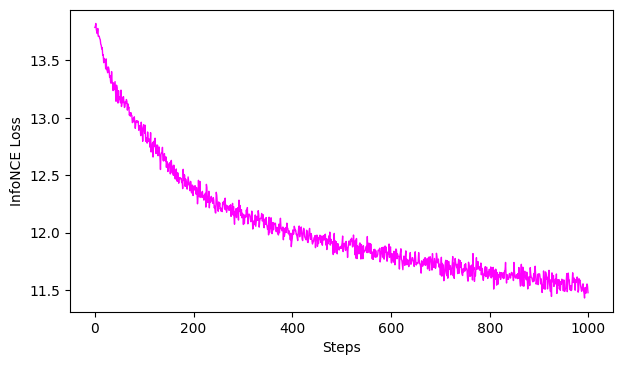

In [9]:
# Plot loss function and save model
cebra.plot_loss(S01_cebra_model)
S01_cebra_model.save(S01_model_path)

In [10]:
# # Plot loss function and save model
# cebra.plot_loss(S02_Apr26_cebra_model)
# S02_Apr26_cebra_model.save(S02_Apr26_model_path)

In [11]:
# # Plot loss function and save model
# cebra.plot_loss(S02_Apr27_cebra_model)
# S02_Apr27_cebra_model.save(S02_Apr27_model_path)

### Plot Embedding

In [12]:
def plot_embedding(cebra_model, neural_data, bin_size = 10):

    # Compute the embedding on neural data
    embedding = cebra_model.transform(neural_data)

    # Plot the embedding statically
    #cebra.plot_embedding(embedding, embedding_labels = 'time', 
    #                     cmap = 'cool', markersize = 2, alpha = 1)

    # Convert Numpy embedding to Pandas
    embedding = pd.DataFrame(embedding, columns=['X', 'Y', 'Z'])
    embedding = embedding.reset_index().rename(columns = {'index': 'time'})

    # Average to reduce time resolution
    bin_list = np.arange(min(embedding['time']), 
                         max(embedding['time']) + bin_size, 
                         bin_size)
    embedding['bin'] = pd.cut(embedding['time'], 
                            bins = bin_list, 
                            include_lowest = True)
    embedding = embedding.groupby('bin').mean().reset_index()
    embedding = embedding[['X', 'Y', 'Z']].reset_index()

    # Plotly plotting
    fig = px.scatter_3d(embedding, x = 'X', y = 'Y', z = 'Z', 
                        color = 'index', size_max = 0.1, opacity = 1)
    
    return(fig)
    #fig.show()

In [13]:
#S01_cebra_model = cebra.CEBRA.load(S01_model_path)
S01_embedding = plot_embedding(S01_cebra_model, S01_spike_data) 
S01_embedding.show()

### Label Decoding

### Model Evaluation

In [14]:
# 7. Evaluate the model performances
goodness_of_fit = cebra.sklearn.metrics.infonce_loss(cebra_model,
                                                     valid_data,
                                                     valid_discrete_label,
                                                     valid_continuous_label,
                                                     num_batches=5)

# 8. Adapt the model to a new session
cebra_model.fit(new_neural_data, adapt = True)

# 9. Decode discrete labels behavior from the embedding
decoder = cebra.KNNDecoder()
decoder.fit(train_embedding, train_discrete_label)
prediction = decoder.predict(valid_embedding)
assert prediction.shape == (30,)

NameError: name 'cebra_model' is not defined